# Case study
## Improving Simulation Optimization Run Time When Solving For Periodic Review Inventory Policies in A Pharmacy

https://informs-sim.org/wsc21papers/232.pdf

Single echelon supply chain: (A distributor: Hospital Pharmacy, and a supplier: Pharmaceutical Manufacturing Facility)
 - A distributor facing stochastic demand is connected to an infinite supplier.
 - The supplier can be disrupted with probability = 0.001 at given day t.
 - The distributor replenishment policy: (s,S)
 - The product is perishable with shelf life of 90 days.
 - The authors model and simulate the system to find optimum values of policy parameters (s,S) that minimizes total expected cost per day

### Detailed system description:

Inventory Type: Perishable <br>
Inventory position (level at given time t) = inventory on hand + inventory en route <br>
Replenishment Policy: (s,S) When level falls below s, order is placed for (S - current inventory position) units <br>
Review period = 1 day (monitor inventory everyday) <br>

H = Inventory at hand <br>
H' = Inventory at hand that expires at the end of the day t <br>
P = Inventory position = H + inventory en route <br>

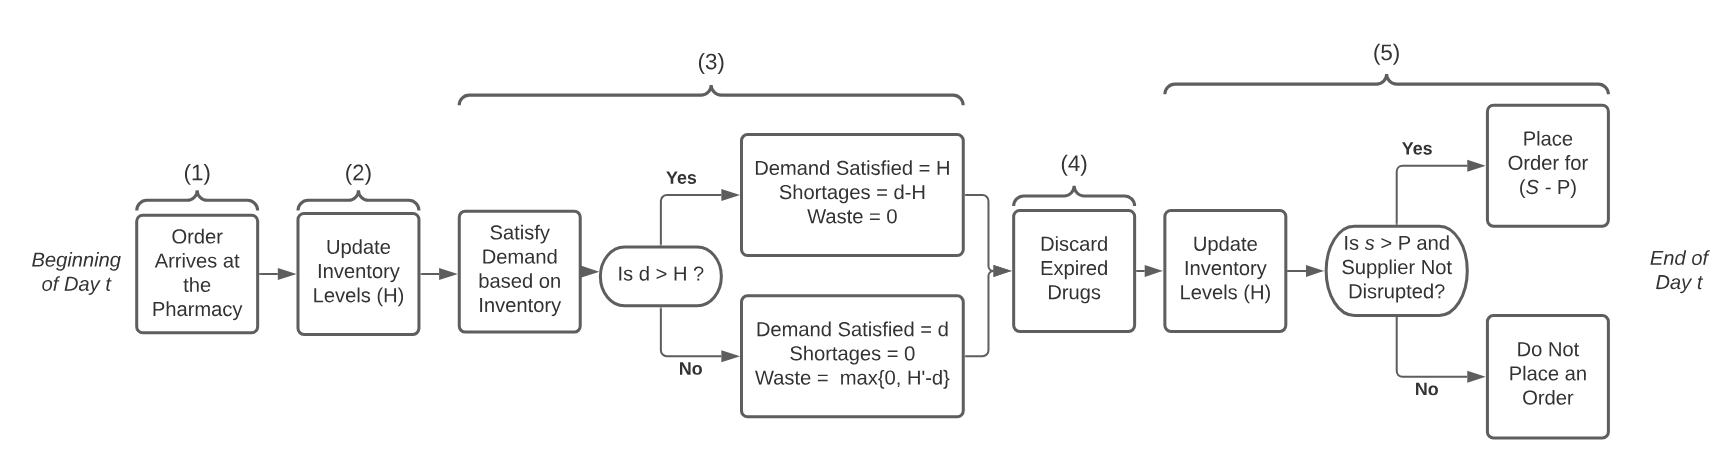

### Algorithm: Process flow of Perishable Inventory
```algorithm
Begin day t
    1. Order arrive at the Pharmacy
    2. Update Inventory Levels (H)
    3. Satisfy demand based on Inventory Levels
        3.1. If (d>H):
            - demand Satisfied = H
            - Shortage = d-H
            - Waste = 0
        3.2. Else:
            - demand Satisfied = d
            - Shortage = 0
            - Waste = max{0,H'-d}
    4. Discard Expired Drugs
    5. Update Inventory Levels (H)
        5.1. Is (s>P) and (Supplier not Disrupted):
            - Place order for (S-P)
        5.2. Else:
            - Do not place order
    6. End of the day t
```
Optimization Objective: Minimize Expected Cost per day <br>
Costs of interest are shortage, waste, holding and ordering <br>

Assumptions:
 - All drugs that arrive in the same month come from the same production batch and have 
 same end of the month expiration date. Hence drugs are only discarded at the end of the month.
 - The inventory on-hand is know each day.
 - Estimated days until inventory expires is known each day.
 - Lead time is deterministic and +ve. The Order placed at the end of the day (t-1), and arrives at the begining of the day t.
 - Demand is stochastic.
 - Supply uncertainty is due to disruptions
 (these two are independent of each other)
 - All demand that is not met is lost.
 - First in first out protocol is followed when serving orders.

Configuration: 
 - T = number of days (360 days)
 - l = deterministic lead time (6 days)
 - e = shelf life of the drugs (months) (3 months)
 - R = number of simulation replication (5000)
 - b = shortage cost (5 units)
 - z = waste cost (1 units)
 - h = holding cost (0.001 units)
 - o = ordering cost (0.5 units)
 - dt = demand on day t (stochastic) (Poission 25/day)
 - yt = binary variable for supply disruption status on day t (yt=0 disrupted, yt=1 available) (stochastic) (p=0.01)
 - disrupt_time ~ Geom(p=0.01)
 - recovery_time ~ Geom(p=1/30)

 No restriction on the probability distribution of these sources of uncertainty

In [3]:
# Import SupplyNetPy components
import sys, os
sys.path.insert(1, '../src/SupplyNetPy/Components')
import core as scm
import utilities as scm

import simpy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [4]:
class Distributions:
    """
    Class to generate random numbers for demand (order quantity) and order arrival arrival times.
    Parameters:
        mu (float): Mean of the exponential distribution for order arrival times.
        lam (float): Lambda parameter of the Poisson distribution for demand (order quantity).        
    """
    def __init__(self,mu=1,lam=1,p=0.01):
        self.mu = mu
        self.lam = lam
        self.p = p

    def poisson_demand(self):
        return np.random.poisson(self.lam)

    def expo_arrival(self):
        return np.random.exponential(self.mu)
    
    def geometric(self):
        return np.random.geometric(self.p,1)[0]

def manufacturer_date_cal(time_now):
    """
    Function to calculate the manufacture date based on the current time.
    Parameters:
        time_now (int): Current time in days.
    """
    man_dt = time_now - (time_now % 30)  # round down to the nearest month
    return man_dt

# Global parameters
T = 360     #number of days (360 days)
l = 6       #deterministic lead time (6 days)
e = 90      #shelf life of the drugs (months) (3 months)
R = 5000    #number of simulation replication (5000)
b = 5       #shortage cost (5 units)
z = 1       #waste cost (1 units)
h = 0.001   #holding cost (0.001 units)
o = 0.5     #ordering cost (0.5 units)
dt = 25     #demand on day t (stochastic) (Poission 25/day)
# yt = binary variable for supply disruption status on day t (yt=0 disrupted, yt=1 available) (stochastic) (p=0.01)
yt_p = 0.01  # ~ Geometric(p=0.01), sampled from Geometric distribution with probability p = 0.01
yt_r = 1/30 # node recovery time ~ Geometric(p=1/30), sampled from Geometric distribution with probability p = 1/30 = 0.033

def single_sim_run(S,s,ini_level):
    """
    Function to run a single simulation with given parameters.
    Parameters:
        S (int): Capacity of the distributor.
        s (int): Reorder point for the distributor.
        ini_level (int): Initial inventory level at the distributor.
    """
    st = Distributions(mu=1,lam=dt)
    disrupt_time = Distributions(p=yt_p)
    recovery_time = Distributions(p=yt_r)
    # create the environment
    env = simpy.Environment()

    # create an infinite supplier
    supplier1 = scm.Supplier(env=env, ID="S1", name="Supplier 1", node_type="infinite_supplier", 
                             node_disrupt_time=disrupt_time.geometric, node_recovery_time=recovery_time.geometric)

    #create the distributor
    distributor1 = scm.InventoryNode(env=env, ID="D1", name="Distributor 1", node_type="distributor",
                                    capacity=S, initial_level=ini_level, inventory_holding_cost=h, inventory_type="perishable",
                                    manufacture_date = manufacturer_date_cal,
                                    shelf_life=e, replenishment_policy="sS", policy_param=[s], product_sell_price=350)
    link1 = scm.Link(env=env,ID="l1", source=supplier1, sink=distributor1, cost=o, lead_time=lambda: l) # link the nodes
    # set demand
    demand1 = scm.Demand(env=env,ID="d1", name="demand 1", 
                        order_arrival_model=lambda:1, # every day
                        order_quantity_model=st.poisson_demand, demand_node=distributor1,
                        tolerance=0.2)
    scm.global_logger.enable_logging() # enable logging
    env.run(until=T) # run the simulation
    # calculate the costs
    instantaneous_levels = np.array(distributor1.inventory.instantaneous_levels)
    instantaneous_levels = instantaneous_levels[instantaneous_levels[:,0]>30] # discard first 30 days data
    if(distributor1.transportation_cost):
        transportation_cost = np.array(distributor1.transportation_cost)
        transportation_cost = transportation_cost[transportation_cost[:,0]>30]
    else:
        transportation_cost = np.array([[0,0]])
    if(distributor1.inventory.inventory.waste):
        waste_arr = np.array(distributor1.inventory.inventory.waste)
        waste_arr = waste_arr[waste_arr[:,0]>30]
    else:
        waste_arr = np.array([[0,0]])
    if(demand1.shortage):
        shortage_arr = np.array(demand1.shortage)
        shortage_arr = shortage_arr[shortage_arr[:,0]>30]
    else:
        shortage_arr = np.array([[0,0]])
    
    print("Shortage cost: ", sum(shortage_arr[:,1])*b)
    print("Waste cost: ", sum(waste_arr[:,1])*z)
    print("Holding Cost: ", sum(instantaneous_levels[:,1])*h)
    print("Transportation Cost: ",sum(transportation_cost[:,1]))
    print("Total Cost: ", (sum(shortage_arr[:,1])*b + sum(waste_arr[:,1])*z + sum(instantaneous_levels[:,1])*h + sum(transportation_cost[:,1]))/((T-30)*(b+z+h+o)))

def run_for_s(s_low,s_high,s_step,capacity,ini_level,num_replications):
    """ Function to run the simulation for a range of reorder points with given number of replications.
    Parameters:
        s_low (int): Lower bound for the reorder point.
        s_high (int): Upper bound for the reorder point.
        s_step (int): Step size for the reorder point.
        capacity (int): Inventory capacity of the distributor.
        ini_level (int): Initial inventory level at the distributor.
        num_replications (int): Number of replications to run for each reorder point.
    """
    st = Distributions(mu=1,lam=dt)
    disrupt_time = Distributions(p=yt_p)
    recovery_time = Distributions(p=yt_r)
    R = num_replications # number of replications
    exp_cost_per_day = []
    for reorder_point in range(s_low,s_high,s_step):
        # initialize the costs
        shortage_cost = 0 
        waste_cost = 0 
        holding_cost = 0 
        ordering_cost = 0 
        exp_cost_arr = []
        for i in range(0,R):
            env = simpy.Environment()
            supplier1 = scm.Supplier(env=env, ID="S1", name="Supplier 1", node_type="infinite_supplier", 
                                    node_disrupt_time=disrupt_time.geometric, node_recovery_time=recovery_time.geometric)
            distributor1 = scm.InventoryNode(env=env, ID="D1", name="Distributor 1", node_type="distributor", capacity=capacity, 
                                             initial_level=ini_level, inventory_holding_cost=h, manufacture_date = manufacturer_date_cal,
                                             inventory_type="perishable", shelf_life=e, replenishment_policy="sS", 
                                             policy_param=[reorder_point], product_sell_price=350)
            link1 = scm.Link(env=env,ID="l1", source=supplier1, sink=distributor1, cost=o, lead_time=lambda: l)
            demand1 = scm.Demand(env=env,ID="d1", name="demand 1", order_arrival_model=lambda:1, 
                                order_quantity_model=st.poisson_demand, demand_node=distributor1, tolerance=0.2)
            scm.global_logger.disable_logging()
            env.run(until=T) # run the simulation

            if(demand1.shortage):
                shortage_arr = np.array(demand1.shortage)
                shortage_arr = shortage_arr[shortage_arr[:,0]>30]
            else:
                shortage_arr = np.array([[0,0]])
            if(distributor1.inventory.inventory.waste):
                waste_arr = np.array(distributor1.inventory.inventory.waste)
                waste_arr = waste_arr[waste_arr[:,0]>30]
            else:
                waste_arr = np.array([[0,0]])
            if(distributor1.transportation_cost):
                transportation_cost_arr = np.array(distributor1.transportation_cost)
                transportation_cost_arr = transportation_cost_arr[transportation_cost_arr[:,0]>30]
            else:
                transportation_cost_arr = np.array([[0,0]])
            instantaneous_levels = np.array(distributor1.inventory.instantaneous_levels)

            shortage_cost = sum(shortage_arr[:,1]) # b = 5 units
            waste_cost = sum(waste_arr[:,1]) # z = 1 units
            holding_cost = sum(instantaneous_levels[30:,1]) # h = 0.001 units
            ordering_cost = sum(transportation_cost_arr[:,1]) # o = 0.5 units

            exp_cost = (shortage_cost*b + waste_cost*z + holding_cost*h + ordering_cost)/((T-30)*(b+z+h+o))*7.45 # product purchase price = 7.45 per units
            exp_cost_arr.append(exp_cost)

        exp_cost_per_day.append((reorder_point, sum(exp_cost_arr)/R, np.std(exp_cost_arr), np.std(exp_cost_arr)/np.sqrt(R)))
        if(reorder_point == s_low):
            print(f"reorder_point, exp_cost_per_day, std, std_err")

        print(f"[{exp_cost_per_day[-1][0]}, {exp_cost_per_day[-1][1]}, {exp_cost_per_day[-1][2]}, {exp_cost_per_day[-1][3]}],")
    return exp_cost_per_day
    #return exp_cost_arr

In [ ]:
import time
"""
# #replications, exe_time, mean, std, std_err
stats = [[1000, 36.960588455200195, 6.892753959530702, 1.5790855623720441, 0.04993506997383537]
         [2000, 72.83167886734009, 6.899195528892991, 1.5609410389738494, 0.034903702720146756]
         [3000, 107.73177003860474, 6.889177613078952, 1.5909215364558675, 0.029046120424588536]
         [4000, 232.6075098514557, 6.877501445232202, 1.5369443565572374, 0.02430122401831408]
         [5000, 336.01277780532837, 6.902543414859252, 1.5330481561141172, 0.021680574941476502]]
"""
stats = []
for replications in [1000, 2000, 3000, 4000, 5000]:
    start_time = time.time()
    exp_cost_arr = run_for_s(s_low=100,s_high=101,s_step=100,capacity=5000,ini_level=5000,num_replications=replications)
    exp_cost_arr = np.array(exp_cost_arr)
    exe_time = time.time() - start_time
    print(f"R ={replications}, exe_time:{exe_time} sec, mean:{np.mean(exp_cost_arr)}, std:{np.std(exp_cost_arr)}, std_err:{np.std(exp_cost_arr)/np.sqrt(R)}")
    stats.append((replications, exe_time, np.mean(exp_cost_arr), np.std(exp_cost_arr), np.std(exp_cost_arr)/np.sqrt(replications)))


Reorder Point, Expected Cost per Day
100, 6.8927539595307
R =1000, exe_time:36.960588455200195 sec, mean:6.892753959530702, std:1.5790855623720441, std_err:0.022331642184540906
Reorder Point, Expected Cost per Day
100, 6.899195528892995
R =2000, exe_time:72.83167886734009 sec, mean:6.899195528892991, std:1.5609410389738494, std_err:0.022075039873815677
Reorder Point, Expected Cost per Day
100, 6.889177613078951
R =3000, exe_time:107.73177003860474 sec, mean:6.889177613078952, std:1.5909215364558675, std_err:0.0224990281352733
Reorder Point, Expected Cost per Day
100, 6.877501445232221
R =4000, exe_time:232.6075098514557 sec, mean:6.877501445232202, std:1.5369443565572374, std_err:0.02173567553656035
Reorder Point, Expected Cost per Day
100, 6.9025434148592515
R =5000, exe_time:336.01277780532837 sec, mean:6.902543414859252, std:1.5330481561141172, std_err:0.021680574941476502


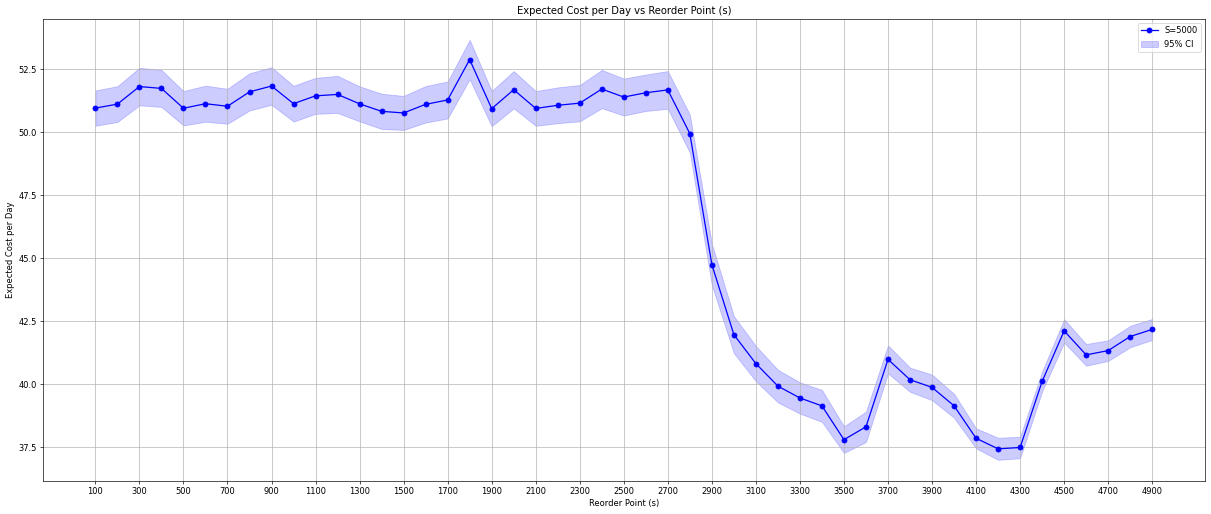

In [5]:
s_low = 100
s_high = 5000
s_step = 100
capacity = 5000
ini_level = 5000
num_rep = 1000

#exp_cost_per_day = run_for_s(s_low=s_low,s_high=s_high,s_step=s_step,capacity=capacity,ini_level=ini_level,num_replications=num_rep)
#exp_cost_per_day = np.array(exp_cost_per_day)

exp_cost_per_day = np.array([[100, 50.96449710925597, 11.067043019697127, 0.3499706290531063],[200, 51.120712888809635, 11.222505720947733, 0.3548867913246485],
[300, 51.818634797886546, 11.779403047441994, 0.37249743107045147],[400, 51.745240652323886, 11.620628126675149, 0.3674765272210915],
[500, 50.95689307598369, 10.776675777041524, 0.3407884106061612],[600, 51.13802667519674, 11.317842515902862, 0.3579016054934351],
[700, 51.03664312206046, 10.971100756513733, 0.34693666829779785],[800, 51.6069564556502, 11.660516824168237, 0.36873791859084754],
[900, 51.839469176606926, 11.779766285505362, 0.37250891766658256],[1000, 51.139798109917834, 11.257015043305676, 0.35597807191624925],
[1100, 51.45019418024264, 11.27317705742587, 0.3564891596782054],[1200, 51.50596520188036, 11.650336466170145, 0.3684159874041487],
[1300, 51.132503879519675, 10.973778035071517, 0.3470213312795311],[1400, 50.835098537684225, 11.058851750871206, 0.34971159838893984],
[1500, 50.77150201740533, 10.67583623284893, 0.3375995842275432],[1600, 51.113378576978796, 11.443794324442097, 0.36188455139744935],
[1700, 51.28694668943703, 11.598020020833577, 0.3667615961406762],[1800, 52.8901224452415, 12.360416073181698, 0.39087067618608645],
[1900, 50.94294652235326, 11.065770056283348, 0.3499303744154502],[2000, 51.693117423053785, 11.671665380649321, 0.36909046690188013],
[2100, 50.95065241566569, 10.882553814775509, 0.3441365681404477],[2200, 51.075116067621266, 11.233723428262225, 0.35524152637703776],
[2300, 51.16019488148681, 11.399727219576018, 0.3604910271847864],[2400, 51.7195472940992, 12.002411197569712, 0.37954956798229506],
[2500, 51.401208703462856, 11.616597891932434, 0.3673490800081703],[2600, 51.57287669834009, 11.417592508976925, 0.3610559772404357],
[2700, 51.68509897999376, 11.837148176070722, 0.37432349237291324],[2800, 49.950442935795465, 11.929139212614393, 0.37723250437089106],
[2900, 44.75513753567045, 13.009800463399452, 0.4114060136865632],[3000, 41.975591128590935, 11.613770232512689, 0.367259661566034],
[3100, 40.826654092727004, 11.048136997546157, 0.3493727681381997],[3200, 39.93402896365591, 10.240006430101417, 0.3238174357389027],
[3300, 39.4639388774688, 9.80633902163966, 0.3101036681616854],[3400, 39.14980607997372, 10.02280175727314, 0.31694882089321225],
[3500, 37.81007338181076, 8.355096156800174, 0.26421133925207874],[3600, 38.32069737776937, 9.50890359276204, 0.3006979340408624],
[3700, 40.99473665725085, 8.783930710119863, 0.2777722785307901],[3800, 40.18802203350999, 7.600685616856845, 0.2403547832814952],
[3900, 39.88433429346534, 8.012476909502345, 0.2533767673353424],[4000, 39.15373568905479, 7.530531924902697, 0.23813632875304583],
[4100, 37.86495817734333, 6.300214596575881, 0.19923027873018645],[4200, 37.44671719565285, 6.911834462273499, 0.2185713971082941],
[4300, 37.498960634494445, 6.740563728014981, 0.21315534094043062],[4400, 40.1202841969534, 6.232524128701845, 0.1970897181865424],
[4500, 42.126466677107935, 7.361476651706649, 0.23279033161543058],[4600, 41.17369243727071, 6.7979020816500615, 0.21496853888814113],
[4700, 41.34330262111193, 6.46200944500086, 0.2043466810772329],[4800, 41.90195727230774, 6.739978931124832, 0.21313684803901609],
[4900, 42.183010775195434, 6.570340895440091, 0.20777242233340906]])

figure(figsize=(25, 10), dpi=60)
plt.plot(exp_cost_per_day[:,0], exp_cost_per_day[:,1],marker='o', linestyle='-', color='b', label='S=5000')
plt.fill_between(exp_cost_per_day[:,0], exp_cost_per_day[:,1]-2*exp_cost_per_day[:,3], exp_cost_per_day[:,1]+2*exp_cost_per_day[:,3],alpha=0.2, color='b', label='95% CI')
plt.xlabel('Reorder Point (s)')
plt.ylabel('Expected Cost per Day')
plt.xticks(np.arange(s_low, s_high, 200))
plt.title('Expected Cost per Day vs Reorder Point (s)')
plt.legend()
plt.grid()
plt.show()

In [6]:
#exp_cost_per_day2 = run_for_s(s_low=s_low,s_high=4000,s_step=s_step,capacity=4000,ini_level=4000,num_replications=num_rep)
#exp_cost_per_day2 = np.array(exp_cost_per_day2)

exp_cost_per_day2 = np.array([[100, 39.86220666867104, 11.61562562941447, 0.3673183343677665],
[200, 40.251330979406454, 12.104257397711697, 0.38277022761711543],
[300, 39.762890111754366, 11.990967534931423, 0.3791876875951794],
[400, 40.1261074227974, 11.621728141670275, 0.36751131274954085],
[500, 40.9319640809339, 12.764476660743856, 0.4036481938801097],
[600, 40.273608501535925, 12.203875397168405, 0.38592042535944154],
[700, 39.56155881116192, 11.246731402302386, 0.35565287463415024],
[800, 39.72549519421254, 11.274291475613627, 0.35652440067559765],
[900, 40.30021164438572, 12.809958069260043, 0.405086442301147],
[1000, 40.23508902234158, 11.786406568402318, 0.37271890184920503],
[1100, 40.34811900285742, 12.06512961654942, 0.3815328985345012],
[1200, 40.20906582052644, 11.742911003850852, 0.3713434513282299],
[1300, 39.6606706548177, 11.662103820151804, 0.3687881038103037],
[1400, 39.9503647866995, 11.733113583824375, 0.3710336297034597],
[1500, 39.68162419436637, 11.72893164527029, 0.3709013851948019],
[1600, 40.087902174117716, 11.972055683476462, 0.37858964234149495],
[1700, 39.10877931998805, 12.074547047670679, 0.3818307038550105],
[1800, 39.348743509879576, 12.006082765544015, 0.3796656731561243],
[1900, 35.45420297021905, 12.722277024003402, 0.4023137241947941],
[2000, 30.77000607493951, 12.30158747052216, 0.3890103524263947],
[2100, 29.210950329483104, 11.390717506382845, 0.36020611503723343],
[2200, 28.3532781787184, 10.329394519391444, 0.3266441353173726],
[2300, 27.956251585373874, 10.246891804327527, 0.32403517038987395],
[2400, 27.444618570080127, 10.150224209959553, 0.32097827264855333],
[2500, 27.42154638892389, 9.547523502388154, 0.30191920281534623],
[2600, 27.163655054210768, 9.74632368560868, 0.3082058165977027],
[2700, 29.34715753909657, 8.90935338957246, 0.2817384919039042],
[2800, 29.270827735919426, 9.00338402241042, 0.284712001599854],
[2900, 28.399867423403414, 7.931233199133712, 0.2508076156320633],
[3000, 27.779174263959334, 8.235568389733633, 0.26043153937643543],
[3100, 26.801726124046194, 7.319784141886572, 0.2314718986914268],
[3200, 26.068582338241697, 7.143005648853426, 0.22588167189825728],
[3300, 26.096145188665616, 6.811797019740819, 0.21540793541127937],
[3400, 29.28009673218109, 7.747785830986059, 0.24500650049096317],
[3500, 30.942628328788633, 7.975580956959157, 0.2522100148705629],
[3600, 29.780386431155108, 6.986474828546053, 0.22093173273639893],
[3700, 29.9508550320463, 6.646212947420217, 0.21017170728348794],
[3800, 31.06311652561618, 7.50891266510411, 0.23745266773014134],
[3900, 30.993708614315732, 7.258756495545394, 0.22954203506465315]])

In [7]:
#exp_cost_per_day3 = run_for_s(s_low=s_low,s_high=3000,s_step=s_step,capacity=3000,ini_level=3000,num_replications=num_rep)
#exp_cost_per_day3 = np.array(exp_cost_per_day3)

exp_cost_per_day3 = np.array([[100, 28.481726700181326, 12.203605056302928, 0.3859118764306463],
[200, 28.341413182167745, 11.52808622505739, 0.3645500953399381],
[300, 28.274860963558076, 11.732987332054027, 0.37102963727193045],
[400, 28.95961444122814, 11.906420609139866, 0.37651407904851386],
[500, 28.80867685018159, 12.597304849703951, 0.39836175704549587],
[600, 28.570472364368182, 12.097290860139918, 0.3825499263557958],
[700, 28.20937046188696, 11.807324261719806, 0.37338037739200647],
[800, 22.594979473787255, 13.840214969643776, 0.437666026104325],
[900, 24.63783878806526, 12.765242650697662, 0.40367241660929803],
[1000, 21.030408016878567, 13.458135368210874, 0.4255836082241519],
[1100, 18.211963478788793, 12.364290494558828, 0.39099319614775624],
[1200, 18.38083704910201, 12.711650003122653, 0.4019776682875408],
[1300, 20.02240767119744, 10.78335072300887, 0.3409994909313149],
[1400, 17.59771602977165, 9.933957098526287, 0.3141393060974077],
[1500, 16.41394669745446, 10.819595682105398, 0.34214565717576156],
[1600, 15.445330606456839, 8.85476557581276, 0.2800122736642069],
[1700, 17.956433159933436, 8.638280397103207, 0.2731664112202991],
[1800, 17.7002241202519, 9.613992789309261, 0.3040211462265256],
[1900, 18.37824875811645, 9.277246303495264, 0.29337228733422754],
[2000, 16.324740888557937, 7.937296403375472, 0.2509993509852908],
[2100, 15.412365413013397, 7.60139878299326, 0.24037733557490693],
[2200, 14.97579466291901, 8.082590489638296, 0.25559395341672586],
[2300, 14.85565590242528, 7.370148244416053, 0.23306455145446087],
[2400, 17.895719742044346, 7.796795578810187, 0.24655632479771042],
[2500, 19.586251077386677, 8.219487755261401, 0.25992302506490667],
[2600, 18.883974873842256, 7.796360299599235, 0.24654256006046316],
[2700, 18.96833062796869, 7.741854842230696, 0.24481894615852523],
[2800, 19.210757405527332, 7.42952165677787, 0.23494210360965823],
[2900, 19.24603638319046, 6.429238479183435, 0.20331037214616704]])


In [8]:
#exp_cost_per_day4 = run_for_s(s_low=s_low,s_high=2000,s_step=s_step,capacity=2000,ini_level=2000,num_replications=num_rep)
#exp_cost_per_day4 = np.array(exp_cost_per_day4)

exp_cost_per_day4 = np.array([[100, 19.97616340395184, 11.916406048971034, 0.3768298463815644],
[200, 14.540187766753819, 13.652663805470587, 0.4317351375382905],
[300, 13.133916955922873, 12.962197512733596, 0.4099006762120758],
[400, 10.96207340693508, 12.39891086784429, 0.3920879884780293],
[500, 9.733010211692399, 12.573023311895739, 0.39759390739984146],
[600, 10.267702969077023, 12.247799914556447, 0.3873094405601404],
[700, 10.678641952030686, 11.733687369470431, 0.3710517743987622],
[800, 9.600325577300467, 10.8227949774637, 0.34224682777815996],
[900, 8.694369576242352, 10.751787271346908, 0.34000136695063066],
[1000, 8.48232629224874, 9.58536463255406, 0.30311584442093786],
[1100, 8.063843193284967, 10.662937836538777, 0.33719170112250724],
[1200, 6.5306888739028475, 8.717827478195684, 0.2756819107950025],
[1300, 7.077822120396403, 9.7331954329623, 0.30779066479709577],
[1400, 8.072049149524776, 8.944250976240237, 0.2828420504910372],
[1500, 8.177269862608554, 8.759889885683231, 0.27701204091031023],
[1600, 7.855598168510199, 8.654408519286562, 0.273676427225108],
[1700, 7.877377475166987, 8.572385582297002, 0.27108263421247314],
[1800, 8.310096514871837, 8.127115493237646, 0.2570019576587373],
[1900, 8.391168946106205, 7.832646240299199, 0.24769002225700004]])

In [9]:
#exp_cost_per_day5 = run_for_s(s_low=s_low,s_high=1000,s_step=s_step,capacity=1000,ini_level=1000,num_replications=num_rep)
#exp_cost_per_day5 = np.array(exp_cost_per_day5)

exp_cost_per_day5 = np.array([[100, 25.30862172992034, 15.375530317761504, 0.48621696037098827],
[200, 18.16593400246117, 16.986714360773185, 0.5371670734273444],
[300, 17.650956809395268, 16.973452926426557, 0.5367477100515831],
[400, 15.589053570872546, 16.870657435971335, 0.533497031221257],
[500, 15.498871274512553, 15.421650748015102, 0.48767541643367135],
[600, 13.898840987447143, 15.368269057506792, 0.48598733916010683],
[700, 13.78142778173988, 15.215801669376146, 0.4811658970062092],
[800, 13.20616981550624, 15.448069084740641, 0.48851083759413116],
[900, 11.804738360182338, 13.481785962414833, 0.4263315056811608]])

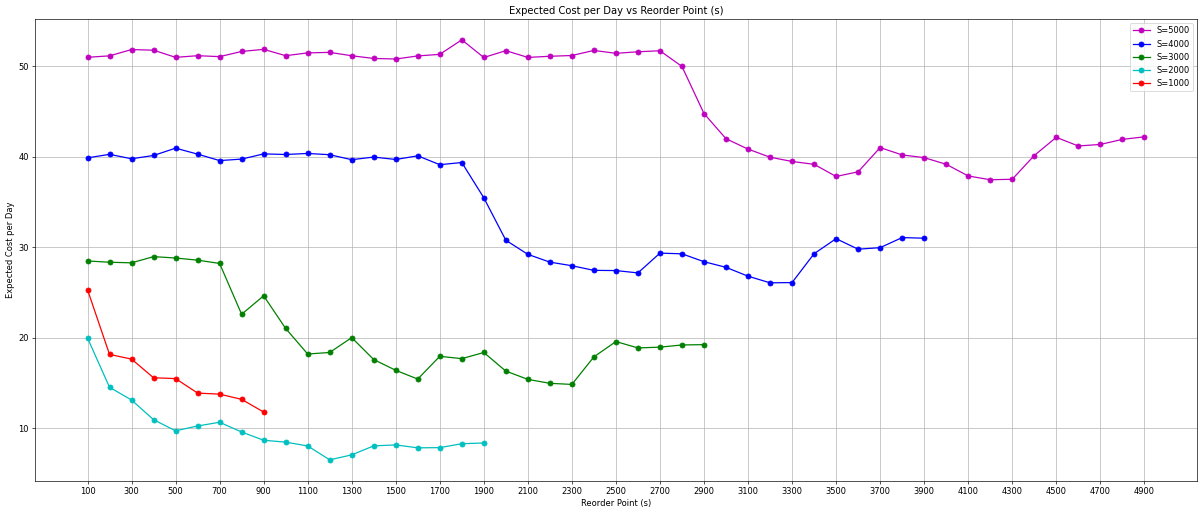

In [10]:
figure(figsize=(25, 10), dpi=60)
plt.plot(exp_cost_per_day[:,0], exp_cost_per_day[:,1],marker='o', linestyle='-', color='m', label='S=5000')
plt.plot(exp_cost_per_day2[:,0], exp_cost_per_day2[:,1],marker='o', linestyle='-', color='b', label='S=4000')
plt.plot(exp_cost_per_day3[:,0], exp_cost_per_day3[:,1],marker='o', linestyle='-', color='g', label='S=3000')
plt.plot(exp_cost_per_day4[:,0], exp_cost_per_day4[:,1],marker='o', linestyle='-', color='c', label='S=2000')
plt.plot(exp_cost_per_day5[:,0], exp_cost_per_day5[:,1],marker='o', linestyle='-', color='r', label='S=1000')
plt.xticks(np.arange(s_low, s_high, 200))
plt.xlabel('Reorder Point (s)')
plt.ylabel('Expected Cost per Day')
plt.title('Expected Cost per Day vs Reorder Point (s)')
plt.legend()
plt.grid()
plt.show()